# Hyperparameter Fishing Continued

In `Your_first_neural_network.ipynb` I began running benchmarks 
across a a number of different hyperparameter permutations.

I saved these results to a pickle dump and CSV which I will read
and analyze within this notebook in order to explore some questions
about picking good hyperparameters for this neural net using the
benchmarks I generated.

## Caveats

**These benchmarks were only trained and evaluated once per hyperparameter. 
Training produces non-deterministic results so there will be slight variance
from run-to-run.**

I have moved forward with this approach because a given hyperparameter 
configuration should yield loss benchmarks that are fairly close in 
performance.

**The data suggests definite trends that I will be opining about here but a good
secondary step would be further sampling of benchmarks for each respective
hyperparameter permutation to gain confidence of the loss benchmarks
calculated**

**<span style='color:red;'>Furthermore, in the worst of cases, my results might be
bogus if I have incorrectly configured my neural net.**  My results
differ from some of the mentor feedback that people shared on Slack; 
this is part of why I decided to dig into hyperparameters so much.  If
I have built my network incorrectly many or all of my findings would
need to be amended.

In [184]:
from operator import itemgetter
import pickle

# in "Your_first_neural_network.ipynb" we generated a pickle dump of 
# the results of various training sessions on a variety of different
# hyperparameters

with open('results.pik', 'rb') as file_obj:
    results = pickle.loads(file_obj.read())

In [5]:
results[0]

(2, 1, 0.01, 500, 1.0446468374636233, 1.2765261941388899)

In [185]:
len(results)

1323000

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotting sorted training loss efficacy

After manually trying parameters I suspected that we get 
diminishing returns after a while as we optimize the 
nets further and further.  I wanted to see if the data
bore this out.

**Note: <span style='color:red'> I picked a good smattering of values for the various hyperparameters.  They were not chosen linearly at all (if anything closer to exponential).  This will affect the overall shape of the curve.**

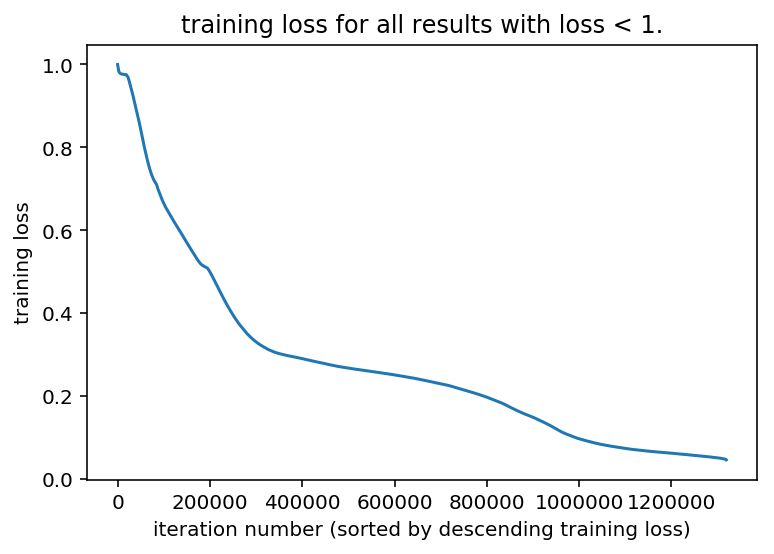

In [90]:
sorted_results = sorted(results, key=lambda x: x[-2], reverse=True)
plt.ylabel('training loss')
plt.xlabel('iteration number (sorted by descending training loss)')
plt.title("training loss for all results with loss < 1.")
plt.plot([x[-2] for x in sorted_results if x[-2] < 1.])

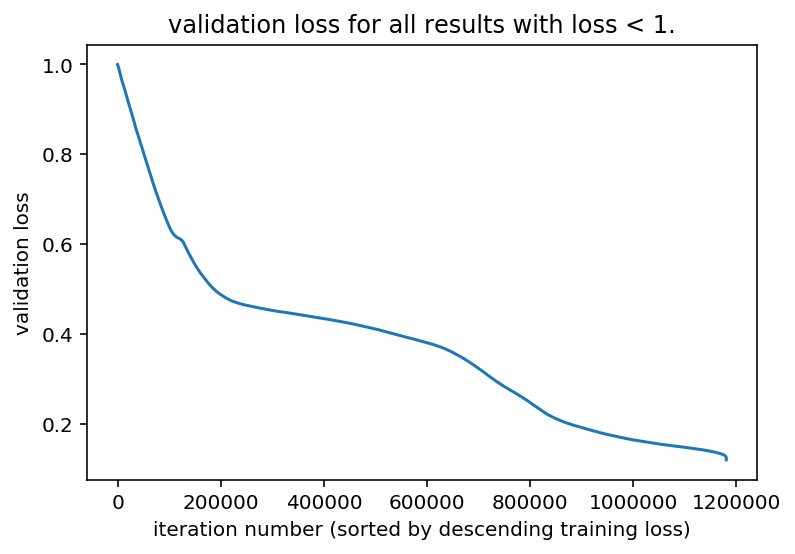

In [99]:
sorted_results = sorted(results, key=lambda x: x[-1], reverse=True)

plt.ylabel('validation loss')
plt.title("validation loss for all results with loss < 1.")
plt.xlabel('iteration number (sorted by descending training loss)')

plt.plot([x[-1] for x in sorted_results if x[-1] < 1.])

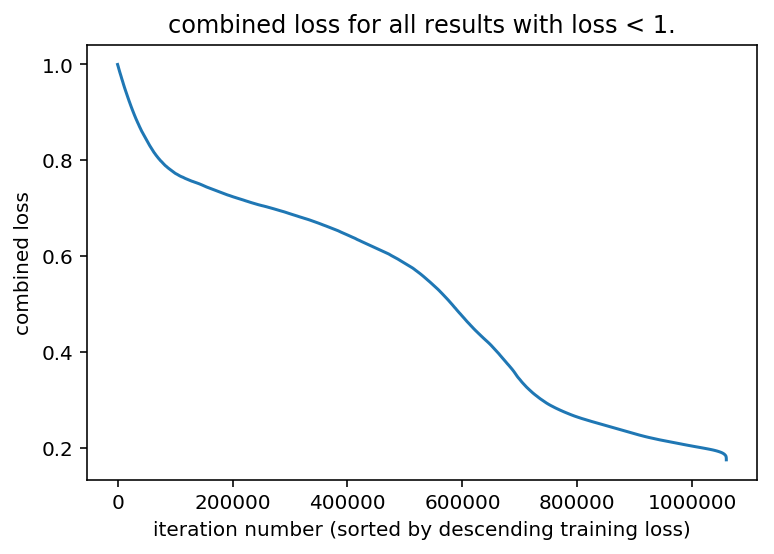

In [96]:
sorted_results = sorted(results, key=lambda x: sum(x[-2:]), reverse=True)

plt.ylabel('combined loss')
plt.title("combined loss for all results with loss < 1.")
plt.xlabel('iteration number (sorted by descending training loss)')

plt.plot([sum(x[-2:]) for x in sorted_results if sum(x[-2:]) < 1.])

**Conclusion**: Even though our hyperparameter brackets aren't linear these 
plots suggest that as training gets more effective we 
experience diminishing returns after a while.

# Hyperparameter Queries / Data Questions

**Note**: I'm focusing on measuring validation loss in the 2nd part
of this analysis because focusing solely on training loss could
run the risk of overfitting.  As our validation set wasn't visible in
the training data it serves as a good metric for how effective a job
at learning our neural net is doing.

Arguably, combined loss (training loss + validation loss) would have
been another way to go.

### SQLite

I also made a `.csv` file of the same results and put it into a sqlite database called `results.sqlite`:

```
sqlite> create table benchmark (hidden_nodes, output_nodes, learning_rate, iterations, train_loss, val_loss);
sqlite> .seperator ","
Error: unknown command or invalid arguments:  "seperator". Enter ".help" for help
sqlite> .separator ","
sqlite> .import results.csv benchmark
```

In this section going to use SQL queries to hone in on data queries 
about hyperparameters

In [103]:
import sqlite3
from pprint import pprint

### Q1: What is the lowest learning rate we can get for neural nets that are effective at learning the validation set?  How is learning rate distributed among these nets?  How is learning rate distribution affected by validation efficacy?

In [180]:
def plot_bar_chart(query_results, title):
    values = []
    labels = []
    for value, label in query_results:
        labels.append(label)
        values.append(value)

    #pprint(sorted(learning_rates, key=lambda x: x[0]), width=5)
    ind = np.arange(len(labels))
    fig, ax = plt.subplots()
    ax.set_title(title)

    ax.bar(ind, values, align='edge', width=.35)
    ax.set_xticks(ind + 0.35/2)
    ax.set_xticklabels(labels)
    plt.show()

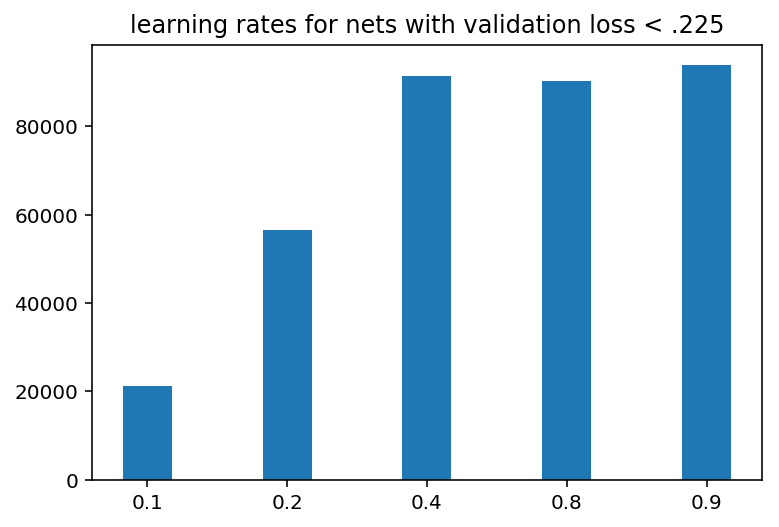

In [181]:
conn = sqlite3.connect('results.sqlite')

c = conn.cursor()

c.execute(
    "select count(learning_rate), learning_rate from benchmark "
    "where val_loss < .225 "
    "group by learning_rate"
)
learning_rates = c.fetchall()
title = "learning rates for nets with validation loss < .225"
plot_bar_chart(learning_rates, title)

I picked `0.225` for the validation loss cutoff after playing around with
the above plots as there seemed to be a slight inflection point where values
leveled off below that.

I also noticed that when training was effective, it was not uncommon to get 
validation loss `<= 0.15` or so, so I also plotted that bar chart:

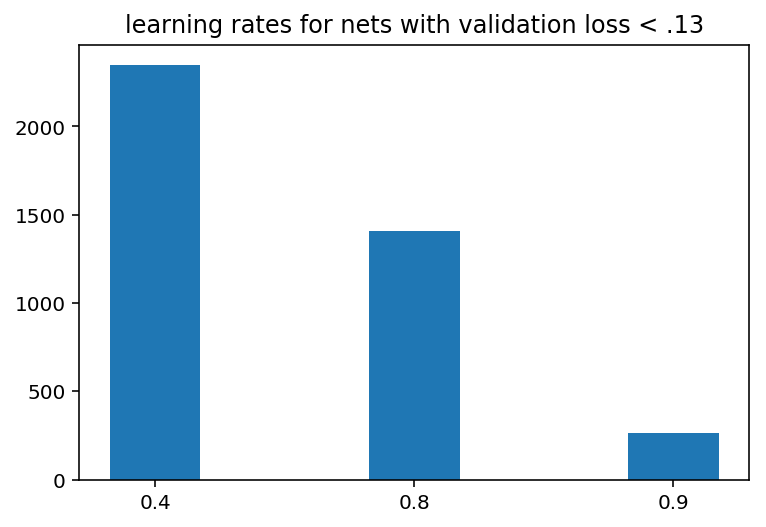

In [194]:
c.execute(
    "select count(learning_rate), learning_rate from benchmark "
    "where val_loss < .13 "
    "group by learning_rate"
)

learning_rates = c.fetchall()
title = "learning rates for nets with validation loss < .13"
plot_bar_chart(learning_rates, title)

**Conclusion: higher learning rates occur more frequently among nets that 
experienced good validation loss within the benchmark data until we reach 
a learning rate of `0.4`, which becomes both the lowest value _and_ most
common when we set the validation loss cutoff down to 0.13**

`0.1` is the lowest possible learning rate value 
for nets with validation loss below `.225`, but it is not represented
nearly as much as higher valued learning rates.  A learning rate 
of `0.1` was not even visible in validation losses below `0.15`;
`0.2` was the lowest.

However, by the time we get to near the upper bound of 
effective validation training at `0.13` or lower we observe
that **`0.4` dominates the greater learning rates**.

This actually runs counter to some of the anecdotal feedback I saw
on Slack and the forums, which suggested that `0.01` was the error
reviewers are looking for.  I can't bear this out in my data; it's 
possible my neural net is built out incorrectly.

### Q2: Is it possible to build an effective neural net with an extremely low learning rate?

In the HW notebook the assignment guidelines suggest ""

I wanted to see if any neural nets with extremely low learning rates 
had managed to get effective scores.

I ran the following query:

```
sqlite> select min(val_loss) from benchmark where learning_rate = 0.01;
0.432506563623
sqlite> select min(train_loss) from benchmark where learning_rate = 0.01;
0.268160070205
```

The minimum validation loss at this learning rate is not much better than 
a coin flip.  Moving to `0.05` fares better, but it is still not very 
effective:

```
sqlite> select min(train_loss) from benchmark where learning_rate = 0.05;
0.123311698551
sqlite> select min(val_loss) from benchmark where learning_rate = 0.05;
0.24343148997
```

It's once we get to a learning rate of `0.1` that we start to get effective results:

```
sqlite> select min(train_loss) from benchmark where learning_rate = 0.1;
0.0742342265709
sqlite> select min(val_loss) from benchmark where learning_rate = 0.1;
0.152336873571
sqlite> 
```

**Conclusion**: **In general, no!**  This surprised me and makes me wonder if my neural net might be built incorrectly.

I'm a little concerned to post this conclusion.  I saw [at least one message on Slack](https://nd101.slack.com/messages/C3QVC209L/search/learning%20rate%200.01/) 
from peers suggesting that a value of `0.01` was preferred, but I cannot find any evidence of 
this with the hyperparameters I've tested.

**I'd be curious if anyone else has evidence suggesting otherwise!**

### Q3: What is the lowest number of epochs we can observe among highly effective validation datasets?  How are number of epochs distributed among these nets?  How are these distributions affected by validation efficacy?

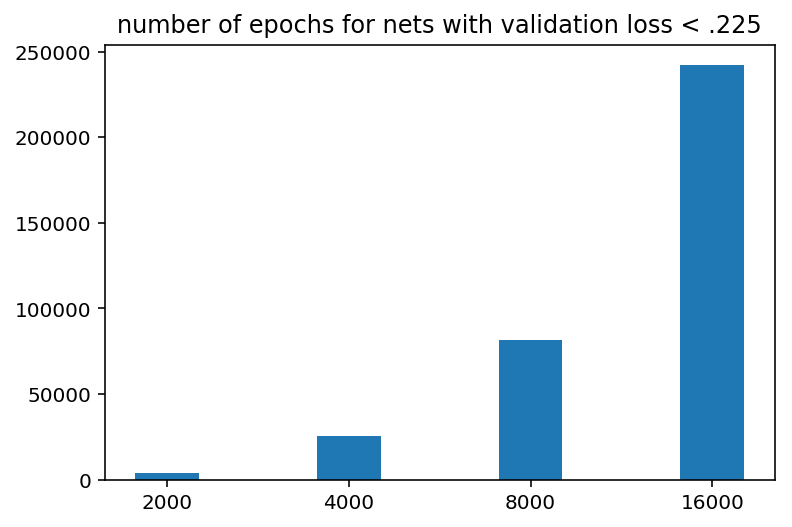

In [195]:
c = conn.cursor()

c.execute(
    "select count(iterations), iterations from benchmark "
    "where val_loss < .225 "
    "group by iterations order by iterations"
)
iterations = c.fetchall()
title = "number of epochs for nets with validation loss < .225"
plot_bar_chart(iterations, title)

Neural nets trained 16,000 times were by far the most dense group across nets with validation loss < 0.225.  This drops off more or less exponentially as the number of epochs decrease at this validation efficacy.

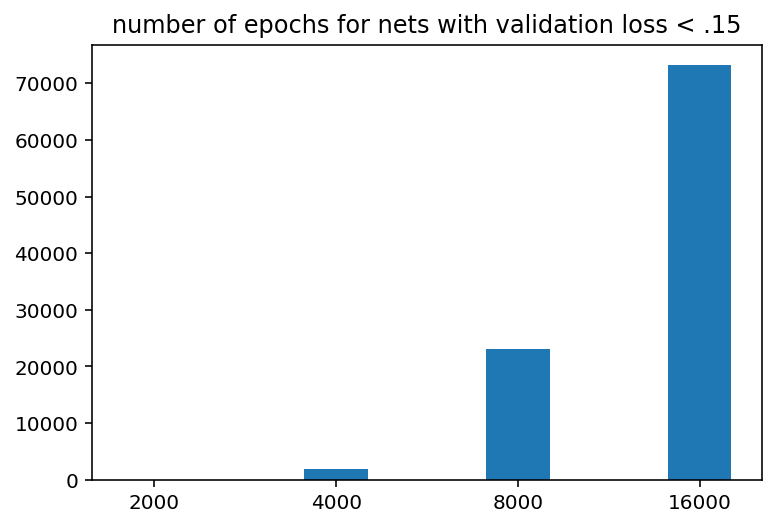

In [166]:

c = conn.cursor()

c.execute(
    "select count(iterations), iterations from benchmark "
    "where val_loss < .15 "
    "group by iterations order by iterations"
)
iterations = c.fetchall()
title = "number of epochs for nets with validation loss < .15"
plot_bar_chart(iterations, title)

The same trend continues when we restrict to neural nets with efficacy
under 0.15.  Nets trained 2,000 times almost drop out of the set entirely.

What about even more effective neural nets at `0.13` or greater?

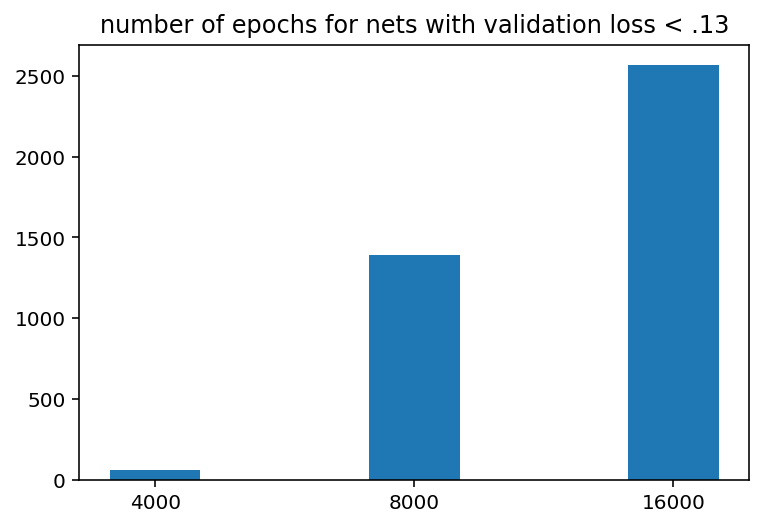

In [189]:
c = conn.cursor()

c.execute(
    "select count(iterations), iterations from benchmark "
    "where val_loss < .13 "
    "group by iterations order by iterations"
)
iterations = c.fetchall()
title = "number of epochs for nets with validation loss < .13"
plot_bar_chart(iterations, title)

**Conclusion: Lower validation losses suggest higher number of 
epochs, in general.**


**Unlike learning rate (which seemed centered around 0.4), 
this trend seems consistent as we increase validation 
efficacy cutoff**

It _is_ however possible to build effective nets with 4,000 
samples or even less if you're willing accept validation 
losses as high as `0.225`.

## Q4: What does the distribution of hidden nodes look like?  How is this distribution affected by validation efficacy?


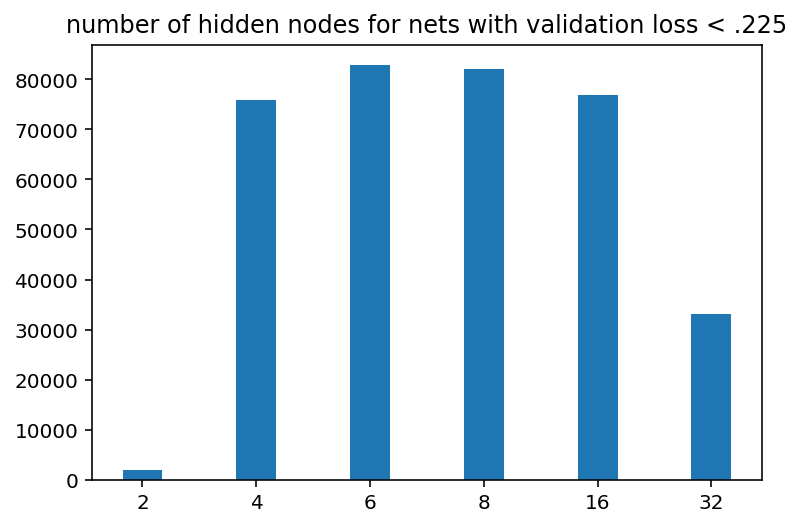

In [204]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .225 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .225"
plot_bar_chart(iterations, title)

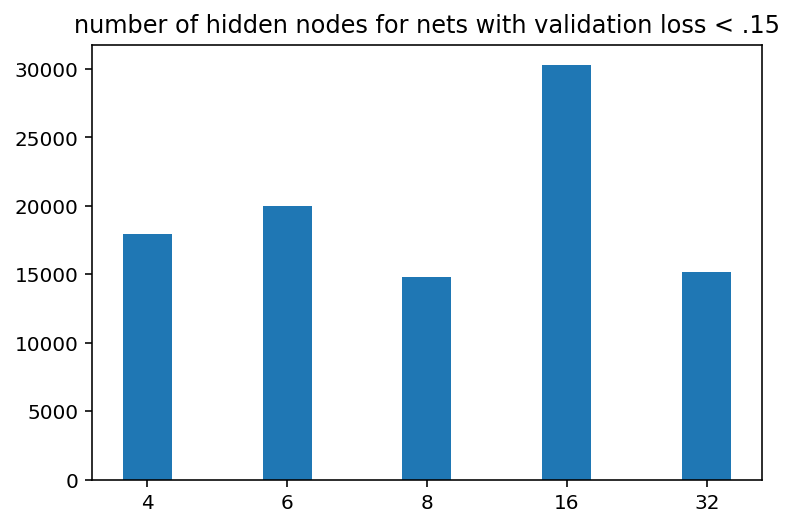

In [203]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .15 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .15"
plot_bar_chart(iterations, title)

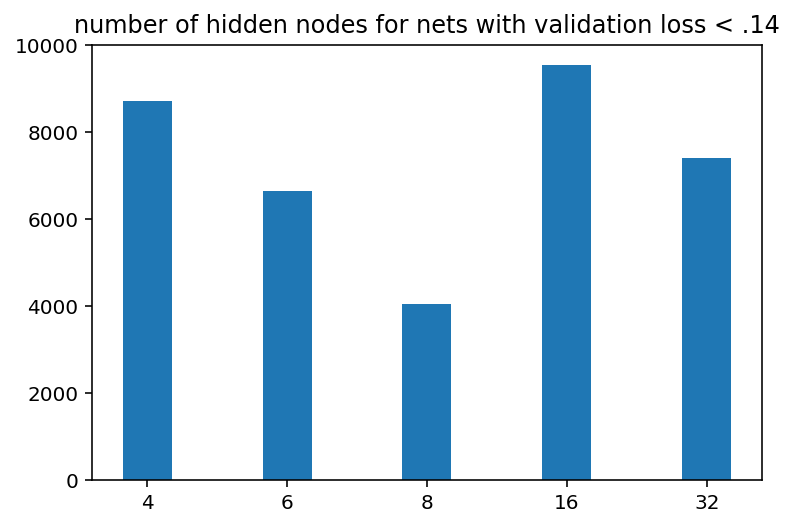

In [202]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .14 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .14"
plot_bar_chart(iterations, title)

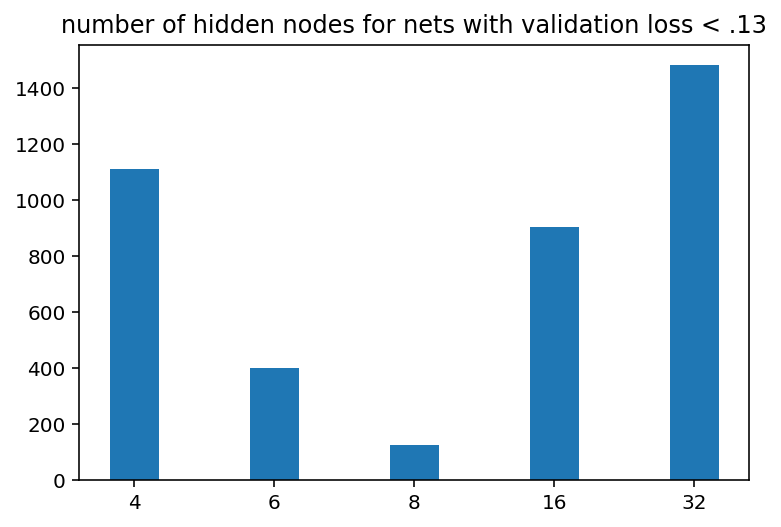

In [197]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .13"
plot_bar_chart(iterations, title)

This isn't as obvious.  Really effective nets (< 0.13 validation loss) 
seem to have a bimodal distribution centered around 4 and 32 nodes.

As we get less effective the bimodal distribution sort of distorts
into a gaussian around 4-32 nodes cetered between 6-8 nodes.

This leads me to wonder **for really effective nets, how are hidden nodes affected by 
learning rate and number of epochs?**

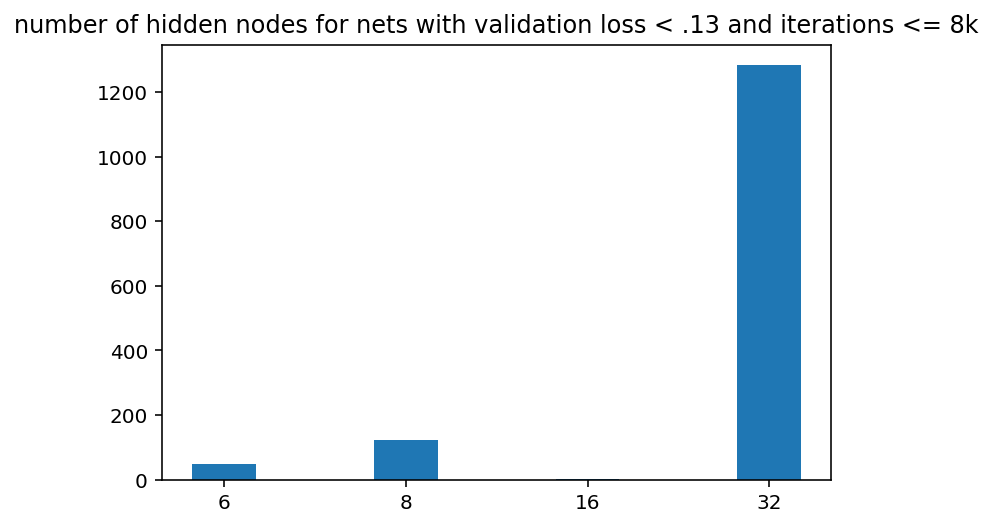

In [210]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 and  iterations <= 8000 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .13 and iterations <= 8k"
plot_bar_chart(iterations, title)

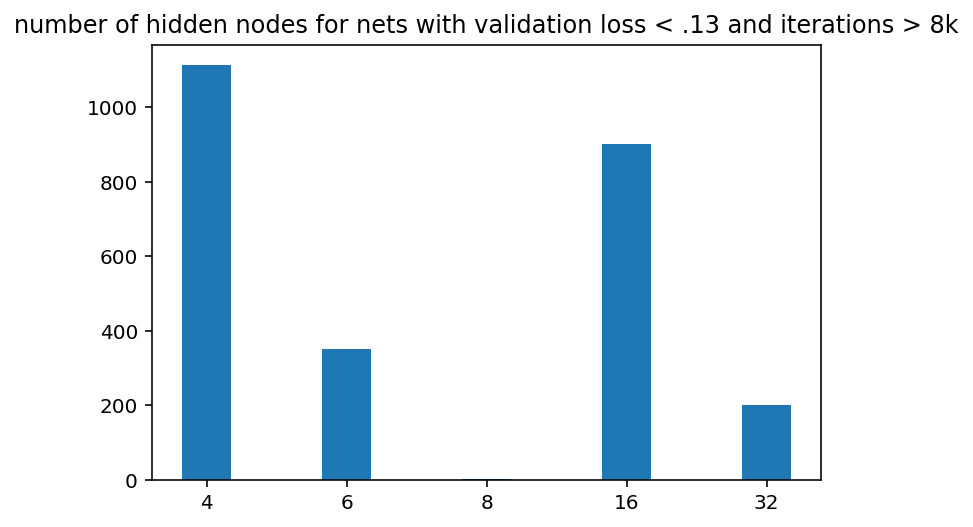

In [209]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 and  iterations > 8000 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .13 and iterations > 8k"
plot_bar_chart(iterations, title)

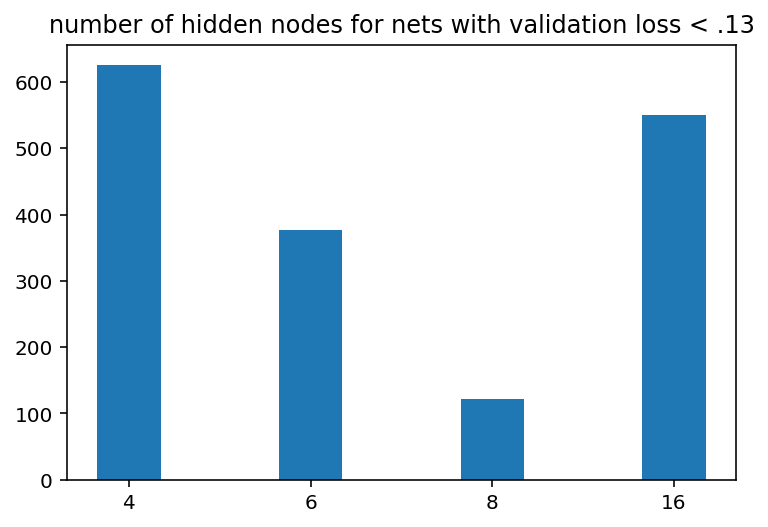

In [211]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 and  learning_rate > 0.4 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .13"
plot_bar_chart(iterations, title)

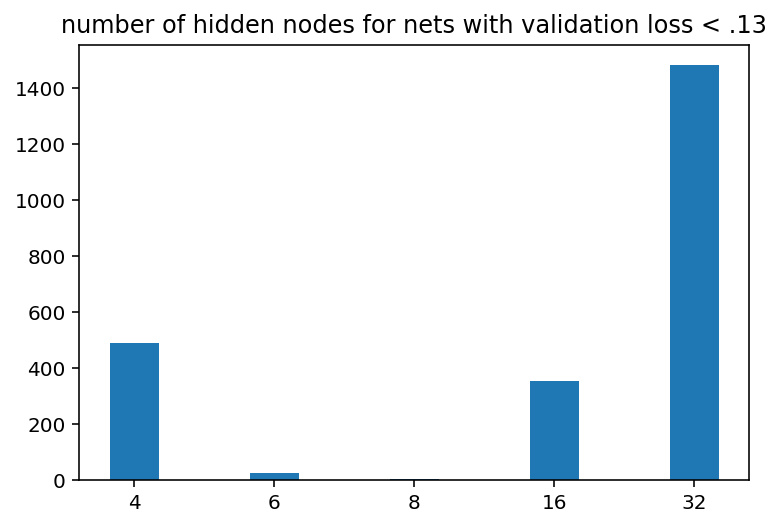

In [212]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 and  learning_rate = 0.4 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "number of hidden nodes for nets with validation loss < .13"
plot_bar_chart(iterations, title)

**note**: there are no nets with val_loss < 0.13 with learning rates < 0.4 in my benchmark set.
    
**Conclusion**: the bimodal distribution around 4 and 32 nodes seems to hold across
a number of learning rates.  **I believe this suggests that learning
rate does not significantly change how the number of hidden nodes 
affects validation loss**

However, when we look at number of epochs we see that lower number of epochs results in nets with 32 
totally dominating the total density.  **I believe this suggests a possible tradeoff between 
number of hidden nodes and iterations**.  We seem to need more hidden nodes if we have less
number of epochs, and need less hidden nodes if we have a higher number of epochs.

# Conclusions

**There seems to be a fundamental a tradeoff between number of epochs and learning rate.**

Higher learning rates mean we can get effective training with fewer number of epochs.

Conversely, we can also get effective training on even the lowest tested learning rate, but 
we need epochs in excess of 16,000 in order to do so.

**Possible implicit tradeoff between number of hidden nodes and number of epochs**

This was a lot less clear, but number of epochs affected the distribution of hidden nodes 
more strongly than learning rate.  Look look two cells up for more information on this possible
finding.

**My data suggests that learning rates < 0.1 are ineffective**

As I mentioned earlier, this runs counter to what at least one peer mentioned
was the suggested feedback by a mentor.  I'd like to understand this further.

**A learning rate of 0.4 seems most effective.**

This value became the most dominant when we restricted ourselves to the lowest validation 
losses we experienced in the benchmark set (`0.13` or lower).

**Effective learning < 4,000 iterations is definitely possible**

However, as mentioned above, it seems to require a higher learning rate.  This could 
probably be bad in situations where 

On the Stanford [CS 231](http://cs231n.github.io/neural-networks-3/#anneal) website they mention:

> Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. 

I believe that this high of a learning rate is probably really bad for a lot of problems and
happens to work well with the spikey function we're predicting. The neural nets consistently has
some issues predicting adequate seasonal demand around Dec 22-Dec 31.  This could be because
that part of the season is somewhat outlier from the rest of the data or possibly because of how
the validation set was constructed.

## Learning Rate vs. Number of Epochs

### What learning rate and number of hidden nodes do you want with a low number of epochs?

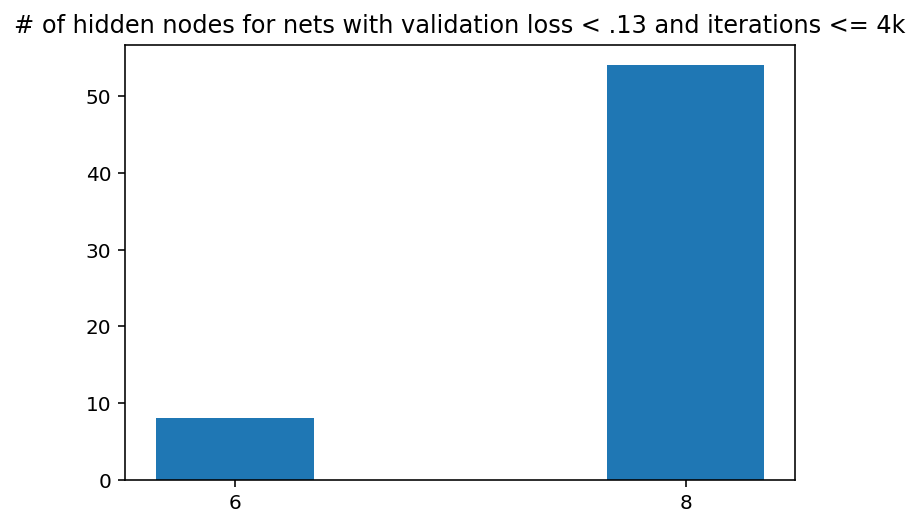

In [230]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .13 and  iterations <= 4000 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "# of hidden nodes for nets with validation loss < .13 and iterations <= 4k"
plot_bar_chart(iterations, title)

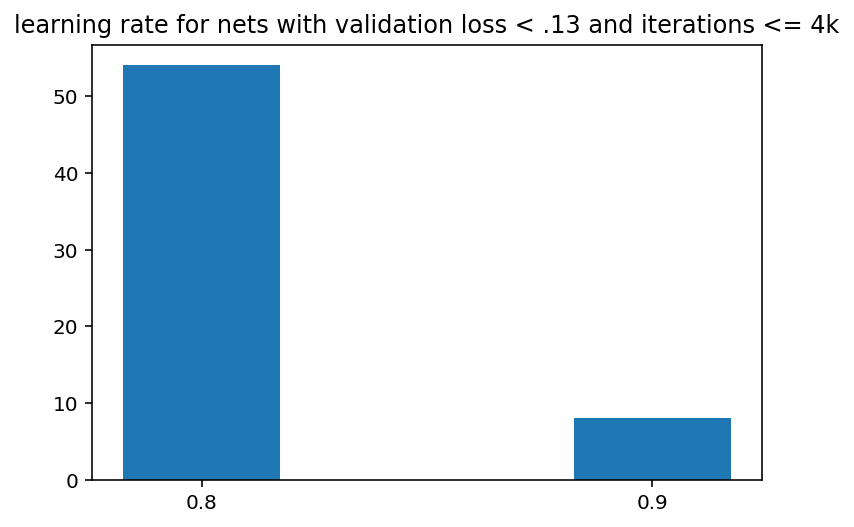

In [231]:
c = conn.cursor()

c.execute(
    "select count(learning_rate), learning_rate from benchmark "
    "where val_loss < .13 and  iterations <= 4000 "
    "group by learning_rate order by learning_rate"
)
iterations = c.fetchall()
title = "learning rate for nets with validation loss < .13 and iterations <= 4k"
plot_bar_chart(iterations, title)

Given there's only 2 x 2 values, I thought I'd see which one of the 4 possible 
states yielded the lowest validation loss:

```
sqlite> select min(val_loss) from benchmark where learning_rate = 0.8 and hidden_nodes = 6;
0.121990855737
sqlite> select min(val_loss) from benchmark where learning_rate = 0.8 and hidden_nodes = 6;
0.121990855737
sqlite> select min(val_loss) from benchmark where learning_rate = 0.8 and hidden_nodes = 8;
0.124737204954
sqlite> select min(val_loss) from benchmark where learning_rate = 0.9 and hidden_nodes = 6;
0.120635762511
sqlite> select min(val_loss) from benchmark where learning_rate = 0.9 and hidden_nodes = 8;
0.124901754971
```

The results are somewhat anecdotal since the val_loss of each training session is going to
be non-deterministic and the variance between these values is extremely small.

**Picking a learning rate of 0.8 or 0.9 and using 6 or 8 hidden nodes would be ideal.**

### What number of epochs and number of hidden nodes do you want with a lower learning rate?

**Note**: I had to move up to a validation loss of `0.16` to get results with a learning rate as low as `0.1`.

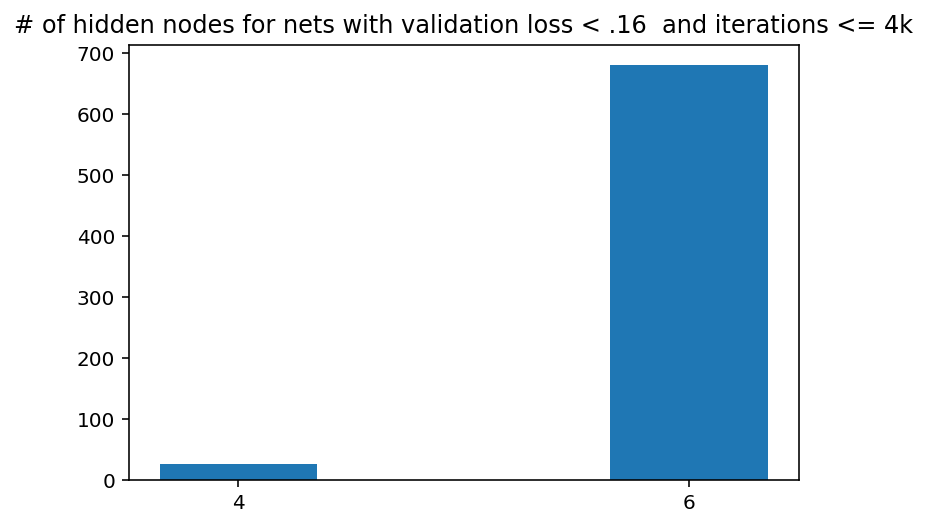

In [232]:
c = conn.cursor()

c.execute(
    "select count(hidden_nodes), hidden_nodes from benchmark "
    "where val_loss < .16 and  learning_rate = 0.1 "
    "group by hidden_nodes order by hidden_nodes"
)
iterations = c.fetchall()
title = "# of hidden nodes for nets with validation loss < .16  and iterations <= 4k"
plot_bar_chart(iterations, title)

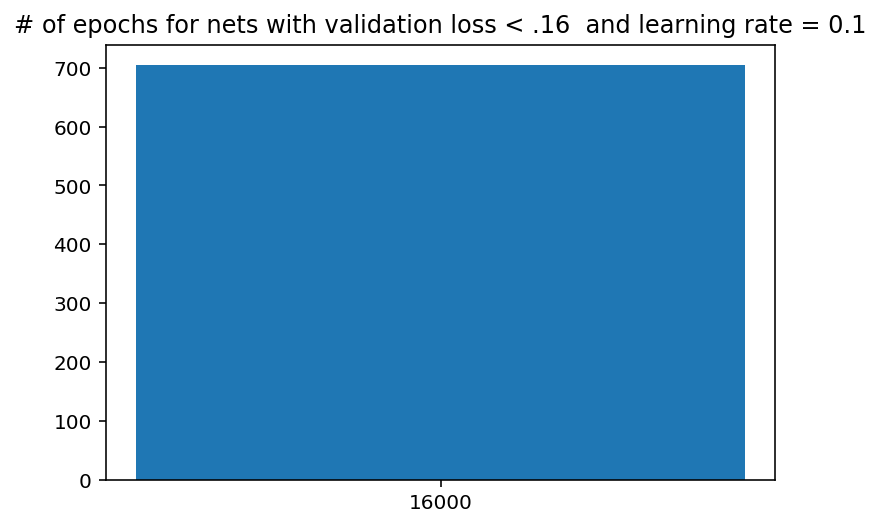

In [233]:
c = conn.cursor()

c.execute(
    "select count(iterations), iterations from benchmark "
    "where val_loss < .16 and  learning_rate = 0.1 "
    "group by iterations order by iterations"
)
iterations = c.fetchall()
title = "# of epochs for nets with validation loss < .16  and learning rate = 0.1"
plot_bar_chart(iterations, title)

First of all, the results yielded by a lower learning rate are both 
less effective and require an unreasonable number of iterations than
the results preferring a lower number of iterations.

I believe the lower learning rate means the weights are adjusted
far less drastically than with a higher learning rate, meaning a
far greater number of iterations are needed to get effective
learning.  The benefit as mentioned in the conclusion section above
is that a lower learning rate will ultimately find "deeper, but 
narrower parts of the loss function."

A lower loss function could probably help us reduce the validation
errors caused by the seasonal peak at the end of December, but we'd 
need an unreasonable number of iterations and would likely get
diminishing returns.

**If you had to pick a lower learning rate, I'd reccomend setting the 
number of hidden nodes to 6 and using as high of a number of epochs
as you're willing to run. **